In [6]:
import random
import math
import uuid
from datetime import datetime, timedelta
import numpy as np
import pandas as pd

In [7]:
# ---------- CONFIG ----------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

NUM_USERS = 10000
NUM_MERCHANTS = 800
NUM_DAYS = 30
AVG_TX_PER_USER_PER_DAY = 0.33   # ~0.33 -> ~100k tx total: 10000 * 30 * 0.33 ≈ 99k
TOTAL_TX_APPROX = int(NUM_USERS * NUM_DAYS * AVG_TX_PER_USER_PER_DAY)
FRAUD_RATE = 0.02                # 2% of transactions labeled fraud (approx)
ROLLING_N = 10                   # for spend_deviation_ratio
BURST_MIN_COUNT = 3              # threshold for burst rule in 60s
SPEND_SPIKE_RATIO = 5.0          # amount >= 5 * user_avg -> spend spike
GEO_IMPOSSIBLE_SPEED = 900       # km/h
START_DATE = datetime(2025, 9, 1)  # start timestamp

OUTPUT_CSV = "synthetic_fraud_data.csv"

In [8]:
CITIES = [
    ("New York", 40.7128, -74.0060),
    ("Los Angeles", 34.0522, -118.2437),
    ("Chicago", 41.8781, -87.6298),
    ("Houston", 29.7604, -95.3698),
    ("Phoenix", 33.4484, -112.0740),
    ("London", 51.5074, -0.1278),
    ("Paris", 48.8566, 2.3522),
    ("Berlin", 52.5200, 13.4050),
    ("Madrid", 40.4168, -3.7038),
    ("Rome", 41.9028, 12.4964),
    ("Toronto", 43.6532, -79.3832),
    ("Vancouver", 49.2827, -123.1207),
    ("Mexico City", 19.4326, -99.1332),
    ("São Paulo", -23.5505, -46.6333),
    ("Buenos Aires", -34.6037, -58.3816),
    ("Delhi", 28.6139, 77.2090),
    ("Mumbai", 19.0760, 72.8777),
    ("Bangalore", 12.9716, 77.5946),
    ("Singapore", 1.3521, 103.8198),
    ("Tokyo", 35.6895, 139.6917),
    ("Seoul", 37.5665, 126.9780),
    ("Shanghai", 31.2304, 121.4737),
    ("Beijing", 39.9042, 116.4074),
    ("Sydney", -33.8688, 151.2093),
    ("Melbourne", -37.8136, 144.9631),
    ("Cape Town", -33.9249, 18.4241),
    ("Johannesburg", -26.2041, 28.0473),
    ("Istanbul", 41.0082, 28.9784),
    ("Dubai", 25.2048, 55.2708),
    ("Bangkok", 13.7563, 100.5018),
]
NUM_CITIES = len(CITIES)


In [9]:
# ---------- Helper functions ----------
def random_ip():
    return ".".join(str(random.randint(1, 254)) for _ in range(4))

def haversine_km(lat1, lon1, lat2, lon2):
    # returns distance in km
    R = 6371.0
    phi1, phi2 = math.radians(lat1), math.radians(lat2)
    dphi = math.radians(lat2 - lat1)
    dlambda = math.radians(lon2 - lon1)
    a = math.sin(dphi/2.0)**2 + math.cos(phi1)*math.cos(phi2)*(math.sin(dlambda/2.0)**2)
    return 2*R*math.asin(math.sqrt(a))


In [10]:
# ---------- Create catalogs ----------
print("Creating users, merchants, devices...")
users = []
for uid in range(NUM_USERS):
    user_id = f"u{uid:06d}"
    home_city_idx = random.randrange(NUM_CITIES)
    home_city, home_lat, home_lon = CITIES[home_city_idx]
    # user average spend: log-normal around 30–200
    avg_spend = float(np.random.lognormal(mean=np.log(50), sigma=0.8))
    # active hours: choose two intervals (peak day time)
    start_hour = random.choice([7,8,9,10,11,12,13,14,15,16,17,18,19])
    users.append({
        "user_id": user_id,
        "home_city": home_city,
        "home_lat": home_lat,
        "home_lon": home_lon,
        "avg_spend": avg_spend,
        "start_hour": start_hour
    })

merchants = [f"m{mid:05d}" for mid in range(NUM_MERCHANTS)]

# each user has 2-4 known devices & ips
user_devices = {}
user_ips = {}
for u in users:
    k = u["user_id"]
    user_devices[k] = [f"d_{k}_{i}" for i in range(random.randint(2,4))]
    user_ips[k] = [random_ip() for _ in range(random.randint(2,4))]

Creating users, merchants, devices...


In [11]:
# ---------- Generate base transactions ----------
print("Generating transactions... (~{:,} target)".format(TOTAL_TX_APPROX))
txs = []  # will be list of dicts

# approximate number of transactions per user over the period from Poisson
mean_tx_per_user_total = AVG_TX_PER_USER_PER_DAY * NUM_DAYS
for u in users:
    u_id = u["user_id"]
    count = np.random.poisson(mean_tx_per_user_total)
    if count <= 0:
        continue
    # sample timestamps within window
    for _ in range(count):
        # pick a random day and a time within user's active window +/- 4 hours
        day_offset = random.randint(0, NUM_DAYS-1)
        # user active hours around start_hour with +/-6h
        hour = (u["start_hour"] + random.randint(-6, 6)) % 24
        minute = random.randint(0, 59)
        second = random.randint(0, 59)
        ts = START_DATE + timedelta(days=day_offset, hours=hour, minutes=minute, seconds=second)
        # amount around user avg with log-normal noise
        amount = float(np.random.lognormal(mean=np.log(u["avg_spend"]+1e-6), sigma=0.9))
        # currency simple pick
        currency = random.choice(["USD","EUR","INR","GBP","AUD","SGD","JPY"])
        merchant = random.choice(merchants)
        # device & ip: mostly known, occasionally pick a random new (we'll mark real new devices in injection)
        device = random.choice(user_devices[u_id])
        ip = random.choice(user_ips[u_id])
        # location: mostly home city, small chance of nearby city (simulate travel)
        if random.random() < 0.05:
            # 5% travel: pick a different city at random
            cidx = random.randrange(NUM_CITIES)
            city, lat, lon = CITIES[cidx]
        else:
            city, lat, lon = u["home_city"], u["home_lat"], u["home_lon"]
        txs.append({
            "transaction_id": str(uuid.uuid4()),
            "user_id": u_id,
            "timestamp": ts,
            "amount": round(amount, 2),
            "currency": currency,
            "merchant_id": merchant,
            "device_id": device,
            "ip": ip,
            "city": city,
            "lat": lat,
            "lon": lon,
            "injected_fraud": 0  # will mark later
        })

print("Generated transactions:", len(txs))

Generating transactions... (~99,000 target)
Generated transactions: 98952


In [12]:
# ---------- Inject fraud patterns ----------
print("Injecting fraud patterns...")
tx_count = len(txs)
num_frauds_target = max(1, int(tx_count * FRAUD_RATE))
print(f"Target frauds: {num_frauds_target} (~{FRAUD_RATE*100:.1f}%)")

# Shuffle tx indexes and pick fraud positions
idxs = np.arange(tx_count)
np.random.shuffle(idxs)
fraud_idxs = set(idxs[:num_frauds_target])

# We will assign fraud types evenly across patterns
fraud_types = ["burst", "spend_spike", "new_device", "new_ip", "geo_impossible", "odd_hour_high"]
# if more frauds than types, they will repeat
for i, fid in enumerate(list(fraud_idxs)):
    fraud_type = fraud_types[i % len(fraud_types)]
    tx = txs[fid]
    user = tx["user_id"]
    # modify tx depending on fraud type
    if fraud_type == "burst":
        # create 2-4 additional rapid transactions within +/-30s of this tx for same user
        base_ts = tx["timestamp"]
        for _ in range(random.randint(2,5)):
            ts = base_ts + timedelta(seconds=random.randint(1,50))
            amount = round(tx["amount"] * np.random.uniform(0.5, 2.0),2)
            txs.append({
                "transaction_id": str(uuid.uuid4()),
                "user_id": user,
                "timestamp": ts,
                "amount": amount,
                "currency": tx["currency"],
                "merchant_id": random.choice(merchants),
                "device_id": tx["device_id"],
                "ip": tx["ip"],
                "city": tx["city"],
                "lat": tx["lat"],
                "lon": tx["lon"],
                "injected_fraud": 1
            })
        tx["injected_fraud"] = 1
    elif fraud_type == "spend_spike":
        # set amount to be very high relative to user avg
        tx["amount"] = round(max(tx["amount"], users[int(tx["user_id"][1:])]["avg_spend"] * SPEND_SPIKE_RATIO * np.random.uniform(1.0, 1.5)), 2)
        tx["injected_fraud"] = 1
    elif fraud_type == "new_device":
        # pick a brand new device id not in user's known list
        new_device = f"d_{user}_new_{uuid.uuid4().hex[:6]}"
        tx["device_id"] = new_device
        tx["injected_fraud"] = 1
    elif fraud_type == "new_ip":
        newip = random_ip()
        tx["ip"] = newip
        tx["injected_fraud"] = 1
    elif fraud_type == "geo_impossible":
        # choose a far away city and set timestamp close to previous time to make speed huge
        far_city_idx = random.randrange(NUM_CITIES)
        far_city, far_lat, far_lon = CITIES[far_city_idx]
        # set timestamp near previous user tx if exists
        tx_time = tx["timestamp"]
        # move tx to far city with very small time delta (5-20 minutes)
        tx["city"], tx["lat"], tx["lon"] = far_city, far_lat, far_lon
        tx["timestamp"] = tx_time + timedelta(minutes=random.randint(1,20))
        tx["injected_fraud"] = 1
    elif fraud_type == "odd_hour_high":
        # set time to 2-4am local and make amount large
        base_day = tx["timestamp"].date()
        ts = datetime.combine(base_day, datetime.min.time()) + timedelta(hours=random.randint(2,4), minutes=random.randint(0,59))
        tx["timestamp"] = ts
        tx["amount"] = round(max(tx["amount"], users[int(tx["user_id"][1:])]["avg_spend"] * 3.0),2)
        tx["injected_fraud"] = 1

# After injection, we may have appended additional txs; rebuild full list
print("Total transactions after injection:", len(txs))

Injecting fraud patterns...
Target frauds: 1979 (~2.0%)
Total transactions after injection: 100107


In [13]:
# ---------- Convert to DataFrame and sort by user and timestamp ----------
df = pd.DataFrame(txs)
# ensure timestamp is datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])
# sort by user then time so derived features compute correctly
df.sort_values(['user_id','timestamp'], inplace=True)
df.reset_index(drop=True, inplace=True)


In [14]:
# ---------- Derived features per user ----------
print("Computing derived features (tx_count_60s, spend_deviation_ratio, is_new_device/ip, required_speed)...")

# Initialize columns
df['hourOfDay'] = df['timestamp'].dt.hour
df['tx_count_60s'] = 0
df['spend_deviation_ratio'] = 1.0
df['is_new_device'] = 0
df['is_new_ip'] = 0
df['required_speed_kmph'] = 0.0

# helper: group by user and process arrays for performance
grouped = df.groupby('user_id', sort=False)

def process_user(group):
    times = group['timestamp'].values.astype('datetime64[s]').astype('int64')  # seconds since epoch
    lats = group['lat'].values
    lons = group['lon'].values
    devices = group['device_id'].values
    ips = group['ip'].values
    amounts = group['amount'].values.astype(float)
    n = len(group)
    tx_count_60s = np.zeros(n, dtype=int)
    spend_dev = np.ones(n, dtype=float)
    is_new_dev = np.zeros(n, dtype=int)
    is_new_ip = np.zeros(n, dtype=int)
    req_speed = np.zeros(n, dtype=float)

    # tx_count_60s via searchsorted trick
    for i in range(n):
        ts = times[i]
        left = np.searchsorted(times, ts - 60)
        tx_count_60s[i] = i - left + 1  # including current
    # spend deviation: rolling mean of previous ROLLING_N transactions (excluding current)
    if n > 1:
        # compute rolling mean using expanding window
        rolling_means = pd.Series(amounts).rolling(window=ROLLING_N, min_periods=1).mean().shift(1).fillna(method='bfill').to_numpy()
        # avoid division by zero
        rolling_means[rolling_means == 0] = 1.0
        spend_dev = amounts / rolling_means
    else:
        spend_dev = np.ones(n)
    # is_new_device & ip: detect first occurrence per user
    seen_devices = {}
    seen_ips = {}
    for i in range(n):
        d = devices[i]
        ip = ips[i]
        if d not in seen_devices:
            is_new_dev[i] = 1
            seen_devices[d] = True
        if ip not in seen_ips:
            is_new_ip[i] = 1
            seen_ips[ip] = True
    # required speed between consecutive tx
    for i in range(1,n):
        dt_seconds = max(1, times[i] - times[i-1])
        dist_km = haversine_km(lats[i-1], lons[i-1], lats[i], lons[i])
        hours = dt_seconds / 3600.0
        speed = dist_km / hours if hours > 0 else dist_km * 3600.0
        req_speed[i] = speed

    out = pd.DataFrame({
        'tx_count_60s': tx_count_60s,
        'spend_deviation_ratio': spend_dev,
        'is_new_device': is_new_dev,
        'is_new_ip': is_new_ip,
        'required_speed_kmph': req_speed
    }, index=group.index)
    return out

# apply group processing (works reasonably for 100k rows)
derived_chunks = []
for user_id, group in grouped:
    derived_chunks.append(process_user(group))
derived_df = pd.concat(derived_chunks).sort_index()
# assign back
df.loc[derived_df.index, derived_df.columns] = derived_df

Computing derived features (tx_count_60s, spend_deviation_ratio, is_new_device/ip, required_speed)...


/tmp/ipython-input-3755828759.py:37: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rolling_means = pd.Series(amounts).rolling(window=ROLLING_N, min_periods=1).mean().shift(1).fillna(method='bfill').to_numpy()


In [15]:
# ---------- Rule flags & rule_score ----------
print("Computing rule flags and rule_score...")
df['rule_burst_60s'] = (df['tx_count_60s'] >= BURST_MIN_COUNT).astype(int)
df['rule_spend_spike'] = (df['spend_deviation_ratio'] >= SPEND_SPIKE_RATIO).astype(int)
df['rule_new_device'] = df['is_new_device']
df['rule_new_ip'] = df['is_new_ip']
df['rule_geo_impossible'] = (df['required_speed_kmph'] >= GEO_IMPOSSIBLE_SPEED).astype(int)
df['rule_odd_hour'] = df['hourOfDay'].isin([1,2,3,4,5]).astype(int)

# rule_score: weighted sum (weights tunable)
weights = {
    'rule_burst_60s': 30,
    'rule_spend_spike': 30,
    'rule_new_device': 25,
    'rule_new_ip': 20,
    'rule_geo_impossible': 40,
    'rule_odd_hour': 10
}
df['rule_score'] = (
    df['rule_burst_60s']*weights['rule_burst_60s'] +
    df['rule_spend_spike']*weights['rule_spend_spike'] +
    df['rule_new_device']*weights['rule_new_device'] +
    df['rule_new_ip']*weights['rule_new_ip'] +
    df['rule_geo_impossible']*weights['rule_geo_impossible'] +
    df['rule_odd_hour']*weights['rule_odd_hour']
)


Computing rule flags and rule_score...


In [16]:
# ---------- Final label: use injected_fraud as primary truth, keep a small noise factor ----------
print("Applying final labels (using injected frauds + small noise)...")
df['fraud_label'] = df['injected_fraud'].copy()
# add small noise: flip label for some injected/non-injected to avoid perfect separation
flip_noise_rate = 0.005
flip_idxs = df.sample(frac=flip_noise_rate, random_state=SEED).index
df.loc[flip_idxs, 'fraud_label'] = 1 - df.loc[flip_idxs, 'fraud_label']

# Ensure fraud prevalence approx FRAUD_RATE
actual_rate = df['fraud_label'].mean()
print(f"Actual fraud prevalence after noise: {actual_rate*100:.2f}% (target {FRAUD_RATE*100:.2f}%)")

# ---------- Shuffle dataset globally (to avoid user-grouped blocks in training) ----------
df_shuffled = df.sample(frac=1.0, random_state=SEED).reset_index(drop=True)


Applying final labels (using injected frauds + small noise)...
Actual fraud prevalence after noise: 3.60% (target 2.00%)


In [17]:
# ---------- Save trimmed columns for ML training ----------
cols_to_save = [
    'transaction_id','user_id','timestamp','amount','currency','merchant_id','device_id','ip',
    'city','lat','lon','hourOfDay','tx_count_60s','spend_deviation_ratio',
    'is_new_device','is_new_ip','required_speed_kmph',
    'rule_burst_60s','rule_spend_spike','rule_new_device','rule_new_ip','rule_geo_impossible','rule_odd_hour',
    'rule_score','fraud_label'
]
# some columns may be missing if generation didn't create them; intersect
cols_to_save = [c for c in cols_to_save if c in df_shuffled.columns]
df_shuffled.to_csv(OUTPUT_CSV, index=False, columns=cols_to_save)
print("Saved CSV:", OUTPUT_CSV, "shape:", df_shuffled.shape)


Saved CSV: synthetic_fraud_data.csv shape: (100107, 26)


In [18]:
# ---------- Quick sanity checks ----------
print("\nSanity checks:")
print("Total transactions:", len(df_shuffled))
print("Fraud count:", int(df_shuffled['fraud_label'].sum()), "Rate:", df_shuffled['fraud_label'].mean())
print("\nFraud counts by rule flags (rows may overlap):")
for flag in ['rule_burst_60s','rule_spend_spike','rule_new_device','rule_new_ip','rule_geo_impossible','rule_odd_hour']:
    if flag in df_shuffled.columns:
        print(f" {flag}: {df_shuffled[(df_shuffled[flag]==1)&(df_shuffled['fraud_label']==1)].shape[0]} fraud rows triggered this flag")

print("\nAmount summary (all / fraud):")
print(df_shuffled['amount'].describe())
if 'fraud_label' in df_shuffled.columns:
    print(df_shuffled[df_shuffled['fraud_label']==1]['amount'].describe())

print("\nExample rows:")
display(df_shuffled.head(6))


Sanity checks:
Total transactions: 100107
Fraud count: 3603 Rate: 0.03599148910665588

Fraud counts by rule flags (rows may overlap):
 rule_burst_60s: 823 fraud rows triggered this flag
 rule_spend_spike: 219 fraud rows triggered this flag
 rule_new_device: 982 fraud rows triggered this flag
 rule_new_ip: 970 fraud rows triggered this flag
 rule_geo_impossible: 77 fraud rows triggered this flag
 rule_odd_hour: 613 fraud rows triggered this flag

Amount summary (all / fraud):
count    100107.000000
mean        105.807727
std         190.156764
min           0.240000
25%          22.500000
50%          50.740000
75%         115.010000
max        9458.060000
Name: amount, dtype: float64
count    3603.000000
mean      151.343272
std       274.928617
min         0.450000
25%        28.440000
50%        69.320000
75%       168.830000
max      6202.320000
Name: amount, dtype: float64

Example rows:


,transaction_id,user_id,timestamp,amount,currency,merchant_id,device_id,ip,city,lat,...,is_new_ip,required_speed_kmph,rule_burst_60s,rule_spend_spike,rule_new_device,rule_new_ip,rule_geo_impossible,rule_odd_hour,rule_score,fraud_label
0,750519d2-a209-424d-b420-f05c3b713e4e,u002277,2025-09-06 08:46:59,7.76,GBP,m00068,d_u002277_0,9.86.100.187,Chicago,41.8781,...,0,0.0,0,0,1,0,0,0,25,1
1,20731b81-3320-4b9a-9c0d-d7b9abc6bfe0,u006813,2025-09-15 19:02:36,50.54,AUD,m00344,d_u006813_1,10.144.33.36,Melbourne,-37.8136,...,0,0.0,0,1,0,0,0,0,30,1
2,c576b0a7-c0e3-4e07-bbc9-18138b6635e8,u000015,2025-09-27 16:11:10,28.50,GBP,m00675,d_u000015_0,76.214.96.7,Bangalore,12.9716,...,1,0.0,0,0,0,1,0,0,20,1
3,28ece70c-6c7a-4e4d-a5f6-f3f1e0504fb5,u005157,2025-09-10 06:53:24,268.40,JPY,m00103,d_u005157_0,73.202.199.72,Bangkok,13.7563,...,0,0.0,0,0,0,0,0,0,0,1
4,398b5c40-0ebc-449b-9865-f786aec5b260,u005094,2025-09-12 08:58:33,56.56,EUR,m00528,d_u005094_2,187.213.159.150,Dubai,25.2048,...,1,0.0,0,0,0,1,0,0,20,1
5,f1d91ece-c751-4082-b2f8-63585dad39d6,u001752,2025-09-20 09:13:12,46.55,JPY,m00363,d_u001752_1,26.63.63.72,Rome,41.9028,...,0,0.0,0,0,0,0,0,0,0,1


In [2]:
import warnings
warnings.filterwarnings('ignore')

!pip -q install scikit-learn xgboost==2.0.3 flask==3.0.0

###1. Load data & pick features you can compute live

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

CSV_PATH = "/content/synthetic_fraud_data.csv"  # change path if needed
df = pd.read_csv(CSV_PATH, low_memory=False, parse_dates=["timestamp"])

print("Shape:", df.shape)
print("Columns:", sorted(df.columns.tolist())[:25], "...")

# Core numeric features your service can compute live
num_feats = [
    "amount",
    "hourOfDay",
    "tx_count_60s",
    "spend_deviation_ratio",
    "required_speed_kmph",
    "is_new_device",  # treat binaries as numeric (no need to one-hot)
    "is_new_ip"
]

# Optional rule flags (if you want the model to see them)
rule_cols = [c for c in df.columns if c.startswith("rule_")]
# Keep them if you want; else set rule_cols = []
rule_cols = rule_cols

# Optional small-cardinality categoricals (skip merchant_id to avoid huge sparse matrix)
cat_feats = []
if "currency" in df.columns:
    cat_feats.append("currency")

# Ensure the columns actually exist
num_feats = [c for c in num_feats if c in df.columns]
cat_feats = [c for c in cat_feats if c in df.columns]

print("Numeric  :", num_feats)
print("Categorical:", cat_feats)
print("Rule cols:", rule_cols)


Shape: (100107, 25)
Columns: ['amount', 'city', 'currency', 'device_id', 'fraud_label', 'hourOfDay', 'ip', 'is_new_device', 'is_new_ip', 'lat', 'lon', 'merchant_id', 'required_speed_kmph', 'rule_burst_60s', 'rule_geo_impossible', 'rule_new_device', 'rule_new_ip', 'rule_odd_hour', 'rule_score', 'rule_spend_spike', 'spend_deviation_ratio', 'timestamp', 'transaction_id', 'tx_count_60s', 'user_id'] ...
Numeric  : ['amount', 'hourOfDay', 'tx_count_60s', 'spend_deviation_ratio', 'required_speed_kmph', 'is_new_device', 'is_new_ip']
Categorical: ['currency']
Rule cols: ['rule_burst_60s', 'rule_spend_spike', 'rule_new_device', 'rule_new_ip', 'rule_geo_impossible', 'rule_odd_hour', 'rule_score']


###2. Build X / y and do a temporal split (preferred). Fallback to stratified.

In [2]:
TARGET = "fraud_label"
assert TARGET in df.columns, "fraud_label column not found."

# Drop rows with missing target
df = df.dropna(subset=[TARGET]).copy()
df[TARGET] = df[TARGET].astype(int)

# Sort by timestamp for time-based split (if timestamp available)
has_ts = "timestamp" in df.columns and np.issubdtype(df["timestamp"].dtype, np.datetime64)
if has_ts:
    df = df.sort_values("timestamp").reset_index(drop=True)
    cutoff_idx = int(len(df) * 0.8)
    train_df = df.iloc[:cutoff_idx].copy()
    test_df  = df.iloc[cutoff_idx:].copy()
else:
    # Fallback: stratified random split
    from sklearn.model_selection import train_test_split
    train_df, test_df = train_test_split(
        df, test_size=0.2, random_state=42, stratify=df[TARGET]
    )

feature_cols = num_feats + rule_cols + cat_feats
X_train = train_df[feature_cols].copy()
X_test  = test_df[feature_cols].copy()
y_train = train_df[TARGET].copy()
y_test  = test_df[TARGET].copy()

print("Train:", X_train.shape, "Test:", X_test.shape, "Pos rate test:", y_test.mean())


Train: (80085, 15) Test: (20022, 15) Pos rate test: 0.03551093796823494


```
Train: (80085, 15)   → 80 085 rows, 15 feature columns in the training set  
Test:  (20022, 15)   → 20 022 rows, 15 feature columns in the test set  
Pos rate test: 0.0355 → 3.55 % of the test rows have fraud_label = 1
```

###3. XGBoost

In [3]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report, confusion_matrix

numeric_cols = num_feats + rule_cols  # treat rule flags as numeric
categorical_cols = cat_feats

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(with_mean=False), numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
    ],
    remainder="drop",
    sparse_threshold=0.3
)

xgb = XGBClassifier(
    n_estimators=250,
    max_depth=4,
    learning_rate=0.08,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    tree_method="hist",
    scale_pos_weight=( (y_train==0).sum() / max(1,(y_train==1).sum()) )
)

pipe_xgb = Pipeline(
    [('pre', preprocess),
     ('clf', xgb)
    ])

pipe_xgb.fit(X_train, y_train)

proba_x = pipe_xgb.predict_proba(X_test)[:,1]
roc_x   = roc_auc_score(y_test, proba_x)
pr_x    = average_precision_score(y_test, proba_x)
print(f"[XGB] ROC-AUC: {roc_x:.4f}  PR-AUC: {pr_x:.4f}")

# For reference only at 0.5 (we'll use 0.20/0.80 for fusion)
pred05 = (proba_x >= 0.5).astype(int)
print(classification_report(y_test, pred05, digits=3))

[XGB] ROC-AUC: 0.8295  PR-AUC: 0.4800
              precision    recall  f1-score   support

           0      0.982     0.916     0.948     19311
           1      0.193     0.543     0.284       711

    accuracy                          0.903     20022
   macro avg      0.587     0.730     0.616     20022
weighted avg      0.954     0.903     0.924     20022



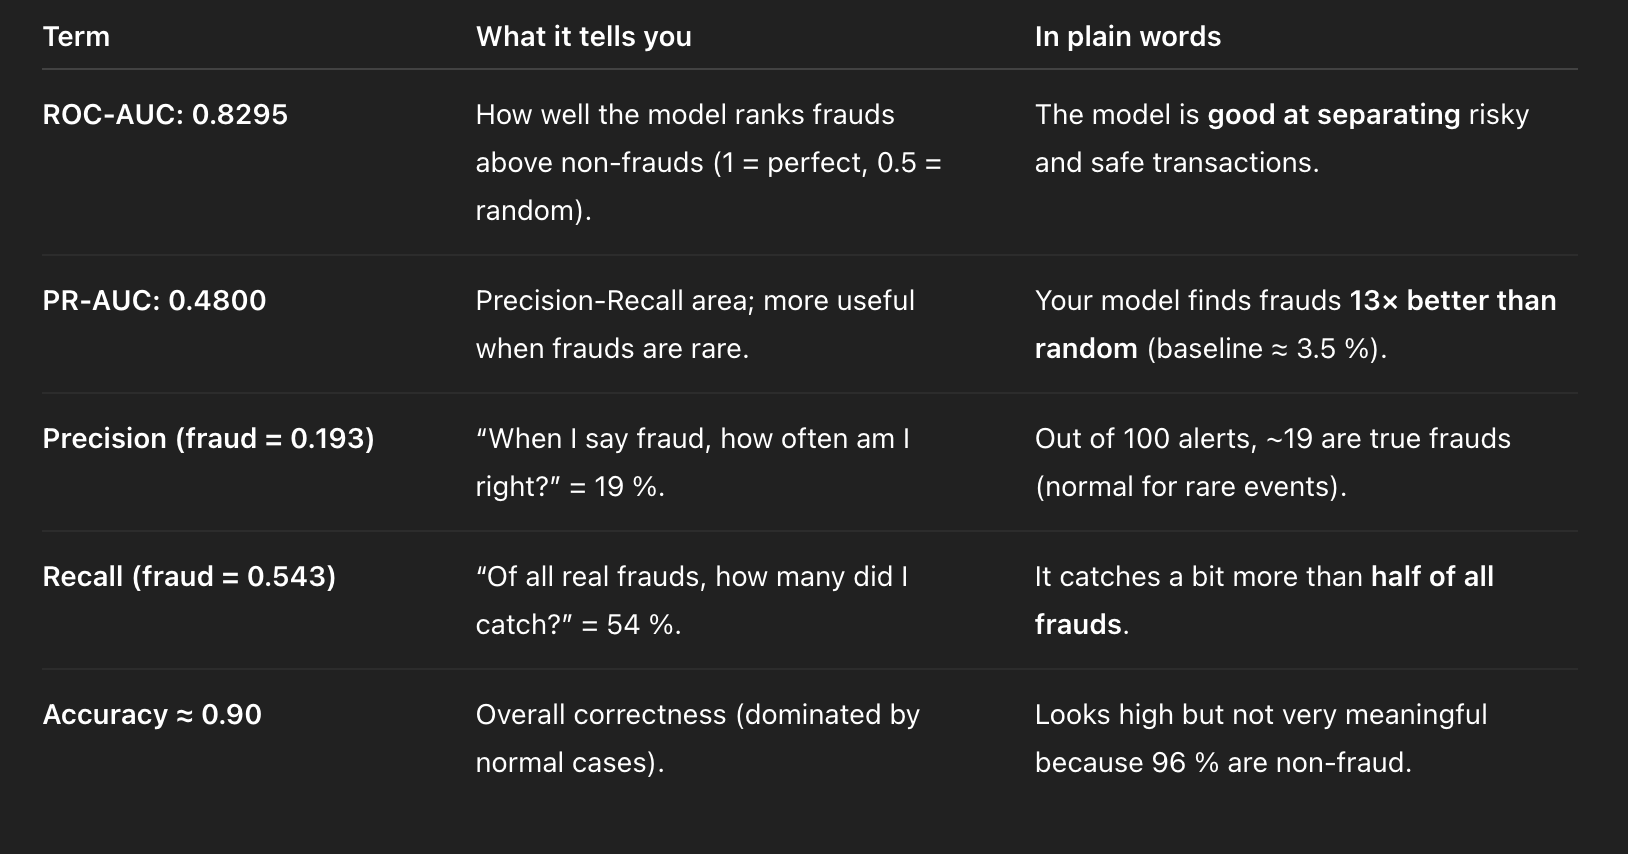

In [4]:
#!pip install --upgrade scikit-learn

###4. Picking a BLOCK threshold

In [5]:
from sklearn.metrics import precision_recall_curve, precision_score, recall_score, confusion_matrix

# proba_x, y_test already exist

# ----- A) Hit a recall target, then take best precision above it -----
RECALL_TARGET = 0.60  # adjust (0.60–0.75 typical for demo)
prec, rec, thr = precision_recall_curve(y_test, proba_x)

mask = rec[:-1] >= RECALL_TARGET            # thr array has len-1 vs rec/prec
candidates = np.where(mask)[0]
if len(candidates) == 0:
    BLOCK_THR = 0.85                        # fallback conservative
else:
    # among candidates, choose threshold with max precision
    best_i = candidates[np.argmax(prec[candidates])]
    BLOCK_THR = float(thr[best_i])

print(f"[A] BLOCK_THR chosen = {BLOCK_THR:.3f}")

[A] BLOCK_THR chosen = 0.458


“If the model’s fraud probability ≥ 0.458, treat it as fraud (BLOCK);
otherwise, it’s safe (ALLOW).”

###5. Evaluating at the threshold

In [6]:
def decide_block(p, thr):
    return (p >= thr).astype(int)  # 1=BLOCK (fraud), 0=ALLOW

pred = decide_block(proba_x, BLOCK_THR)

# Metrics
prec_at = precision_score(y_test, pred, zero_division=0)
rec_at  = recall_score(y_test, pred, zero_division=0)
tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()

block_rate = pred.mean()                          # share predicted BLOCK
specificity = tn / (tn + fp + 1e-12)              # true negative rate

print(f"Threshold = {BLOCK_THR:.3f}")
print(f"Precision (BLOCK) : {prec_at:.3f}")
print(f"Recall    (BLOCK) : {rec_at:.3f}")
print(f"Specificity       : {specificity:.3f}")
print(f"Block rate        : {block_rate:.3f}")
print(f"Confusion matrix  : TN={tn}, FP={fp}, FN={fn}, TP={tp}")


Threshold = 0.458
Precision (BLOCK) : 0.161
Recall    (BLOCK) : 0.603
Specificity       : 0.884
Block rate        : 0.133
Confusion matrix  : TN=17071, FP=2240, FN=282, TP=429


1. Threshold = 0.458

    That’s the score above which the model decides a transaction is fraudulent (BLOCK). Anything below 0.458 is allowed.

2. Precision (BLOCK) = 0.161 → 16 %

    Meaning: Out of all the transactions that the model blocked, only 16 % were actually frauds.

3. Recall (BLOCK) = 0.603 → 60 %

    Meaning: Out of all the actual frauds, the model caught about 60 % of them.

4. Specificity = 0.884 → 88 %

    Meaning: Out of all the normal (non-fraud) transactions, 88 % were correctly allowed.

5. Block rate = 0.133 → 13 %

    Meaning: The model ends up blocking about 13 % of all transactions in total.

```
TN=17071   → Normal transactions correctly allowed
FP=2240    → Normal transactions wrongly blocked  ❌ (false alarms)
FN=282     → Frauds that slipped through  ❌ (missed)
TP=429     → Frauds correctly blocked ✅
```

So, across ~20 000 test transactions:
*   Frauds found: 429
*   Frauds missed: 282
*   Legitimate users wrongly blocked: 2,240
*   Legitimate users passed normally: 17,071

In [7]:
import joblib, json, time

MODEL_PATH = "fraud_model_xgb.pkl"   # your pipeline object
META_PATH  = "model_meta.json"

# These were defined earlier in your notebook:
#   pipe_xgb, num_feats, rule_cols, cat_feats, roc_x, pr_x, BLOCK_THR

feature_cols = (num_feats + rule_cols + cat_feats)
meta = {
    "model_version": f"fraud-xgb-v1-{int(time.time())}",
    "features": feature_cols,
    "block_threshold": float(BLOCK_THR),
    "roc_auc": float(roc_x),
    "pr_auc": float(pr_x)
}

joblib.dump(pipe_xgb, MODEL_PATH)
with open(META_PATH, "w") as f:
    json.dump(meta, f, indent=2)

print("Saved:", MODEL_PATH, META_PATH)


Saved: fraud_model_xgb.pkl model_meta.json


In [13]:
def decide_from_scores(scores, thr):
    return ["BLOCK" if s >= thr else "ALLOW" for s in scores]

sample_idx = np.random.choice(len(proba_x), size=10, replace=False)
sample_scores = proba_x[sample_idx]
sample_truth  = y_test.iloc[sample_idx].tolist()
sample_dec    = decide_from_scores(sample_scores, BLOCK_THR)

pd.DataFrame({
    "score": np.round(sample_scores, 3),
    "decision": sample_dec,
    "is_fraud": sample_truth
})


,score,decision,is_fraud
0,0.126,ALLOW,0
1,0.092,ALLOW,0
2,0.171,ALLOW,0
3,0.195,ALLOW,0
4,0.706,BLOCK,0
5,0.199,ALLOW,0
6,0.547,BLOCK,0
7,0.148,ALLOW,0
8,0.140,ALLOW,0
9,0.125,ALLOW,0


###5. Cross-Validation

In [14]:
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import average_precision_score, roc_auc_score

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_proba = cross_val_predict(pipe_xgb, X_train, y_train, cv=skf, method="predict_proba")[:,1]
print("CV ROC-AUC:", roc_auc_score(y_train, cv_proba))
print("CV PR-AUC :", average_precision_score(y_train, cv_proba))


CV ROC-AUC: 0.7820022531945087
CV PR-AUC : 0.4449223578800663


###6. calibration

In [16]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.pipeline import Pipeline

cal_xgb = CalibratedClassifierCV(estimator=pipe_xgb.named_steps['clf'], method="isotonic", cv=3)

# Rebuild pipeline: reuse same preprocessor, replace classifier with calibrated one
pipe_xgb_cal = Pipeline([
    ("pre", pipe_xgb.named_steps['pre']),
    ("clf", cal_xgb)
])
pipe_xgb_cal.fit(X_train, y_train)

proba_cal = pipe_xgb_cal.predict_proba(X_test)[:,1]
print("Cal ROC-AUC:", roc_auc_score(y_test, proba_cal))
print("Cal PR-AUC :", average_precision_score(y_test, proba_cal))


Cal ROC-AUC: 0.8296343855964561
Cal PR-AUC : 0.48008442129702916


In [17]:
ohe = pipe_xgb.named_steps["pre"].named_transformers_.get("cat")
num_names = num_feats + rule_cols
cat_names = list(ohe.get_feature_names_out(cat_feats)) if ohe is not None else []
final_feature_names = num_names + cat_names

importances = pipe_xgb.named_steps["clf"].feature_importances_
top = sorted(zip(final_feature_names, importances), key=lambda x: x[1], reverse=True)[:15]
for name, imp in top:
    print(f"{name:28s} {imp:.4f}")


rule_burst_60s               0.4947
tx_count_60s                 0.2709
rule_spend_spike             0.0318
rule_odd_hour                0.0260
rule_score                   0.0256
is_new_device                0.0181
rule_new_ip                  0.0168
required_speed_kmph          0.0131
hourOfDay                    0.0118
spend_deviation_ratio        0.0111
rule_geo_impossible          0.0108
amount                       0.0095
currency_JPY                 0.0088
is_new_ip                    0.0076
currency_INR                 0.0074
